In [ ]:
#깃허브에서 KoBERT 파일 로드
!pip install ipywidgets  # for vscode
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-2_u00t95
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-2_u00t95
     |████████████████████████████████| 131 kB 4.1 MB/s 
     |████████████████████████████████| 344 kB 30.7 MB/s 
     |████████████████████████████████| 47.3 MB 150 kB/s 
     |████████████████████████████████| 4.5 MB 54.5 MB/s 
     |████████████████████████████████| 1.2 MB 74.5 MB/s 
     |████████████████████████████████| 3.4 MB 65.7 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
     |████████████████████████████████| 895 kB 72.7 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 55.3 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████| 8.5 MB 55.3 MB/s 
     |████████████████████████████████| 127 kB 91.4 MB/s 
  Created wheel for kobert: filename=kob

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 6s (1,580 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

In [ ]:
# 필요한 모듈 로딩
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

In [ ]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # 한국어 단발성 대화 데이터셋 불러오기 (학습용 데이터)
# # url : https://aihub.or.kr/opendata/keti-data/recognition-laguage/KETI-02-009

# import pandas as pd
# chatbot_data = pd.read_excel('/content/drive/MyDrive/text_data/korean_short_talk.xlsx')

In [ ]:
# 2. 한국어 특정 문자 + 번역기 처리한 데이터 불러와서 학습
import pickle 

# 열기
path = '/content/drive/MyDrive/text_data/'

with open(path+'train_hanspell_new.pickle', 'rb') as f:
    chatbot_data = pickle.load(f)

In [ ]:
len(chatbot_data)

38594

In [ ]:
print(chatbot_data['Emotion'].value_counts())

행복    6037
놀람    5898
분노    5665
공포    5468
혐오    5429
슬픔    5267
중립    4830
Name: Emotion, dtype: int64


텍스트 교정 및 전처리한 데이터로 학습시키기

In [ ]:
# 모델 설정을 위한 변수 전처리 
chatbot_data.loc[(chatbot_data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

In [ ]:
data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
# ['sentence', 'class'] 형태로 잘 넣어졌나 확인
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])
print(data_list[24000])
print(data_list[30000])
print(data_list[-1])

['언니 동생으로 부르는 게 맞는 일인가요..??', '0']
['기술적으로도 아직도 해체해서 다시 완벽히 돌려놓는 게 어려운데 해체를 한다고?', '1']
['당연히 그렇게 해야지 우리나라도 판매를 중단하라', '2']
['그 거들은 뒤부터 미치겠어요...', '3']
['최악의 상황 중 그나마 나은 방법이네. 기분은 잡치겠지만', '4']
['  요리하는 것이 숙제하는 것처럼 힘든 저에게 용기나 게 해주시고 할 수 있을 것 같은 희망을 주셔서 감사합니다!!', '5']
['와이프도 그렇고 댓글 다 볼 텐데 이휘재 좀 하차하라고 전해주세요', '6']


In [ ]:
# train & test set 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=1)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

28945
9649


In [ ]:
# KoBERT 입력 데이터로 만들기
# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
# 이건 나중에 최적화 값 찾아봐야할 듯
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
# 토큰화 실행
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
len(dataset_train[0][0])

32

In [ ]:
dataset_train[0]

['폭스콘과 함께 폭만하려는 샤프 심히 우려가 되네~~~~~!', '0']

In [ ]:
# 토큰화 패딩 처리 후 결과값 
data_train[0]

(array([   2, 4871, 6664, 7539, 5468, 4983, 4871, 6150, 7808,  517, 6546,
        7753, 3060, 7996, 3500, 1763, 5702,  517,  463,  517,  463,  517,
         463,  517,  463,  517,  463,  517,    5,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(30, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [ ]:
# torch 형식의 dataset 생성
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# KoBERT 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정해줘야함##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
train_dataloader

In [ ]:
# # 최종 모델 학습시키기
# for e in range(num_epochs):
#     train_acc = 0.0
#     test_acc = 0.0
#     model.train()
#     for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
#         optimizer.zero_grad()
#         token_ids = token_ids.long().to(device)
#         segment_ids = segment_ids.long().to(device)
#         valid_length= valid_length
#         label = label.long().to(device)
#         out = model(token_ids, valid_length, segment_ids)
#         loss = loss_fn(out, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#         optimizer.step()
#         scheduler.step()  # Update learning rate schedule
#         train_acc += calc_accuracy(out, label)
#         if batch_id % log_interval == 0:
#             print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
#     print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
#     model.eval()

#     for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
#         token_ids = token_ids.long().to(device)
#         segment_ids = segment_ids.long().to(device)
#         valid_length= valid_length
#         label = label.long().to(device)
#         out = model(token_ids, valid_length, segment_ids)
#         test_acc += calc_accuracy(out, label)

#     print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

In [ ]:
# import pickle

# path = '/content/drive/MyDrive/text_data/'

# with open(path+'model_hanspell_new.pickle', 'wb') as f:
#     pickle.dump(model, f)

In [ ]:
# 학습한 model 열기
path = '/content/drive/MyDrive/text_data/'

with open(path+'model_hanspell_new.pickle', 'rb') as f:
    model = pickle.load(f)

In [ ]:
# 새로운 문장 테스트
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# # 예측 함수 생성
# # torch 데이터 타입으로 좀 더 쉽게 할 수 있을 거 같은데, 일단은 모르겠어서 하나씩 예측하는 함수로 실행
# def predict(predict_sentence):

#     data = [predict_sentence, '0']
#     dataset_another = [data]

#     another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
#     test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
#     model.eval()

#     for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
#         token_ids = token_ids.long().to(device)
#         segment_ids = segment_ids.long().to(device)

#         valid_length= valid_length
#         label = label.long().to(device)

#         out = model(token_ids, valid_length, segment_ids)

#         output = out.detach().cpu().numpy()

#     return np.argmax(output)

In [ ]:
import pandas as pd

test = pd.DataFrame(dataset_test)
test.columns = ['sentence', 'label']
test

,sentence,label
0,너무 감사해요.,5
1,언제나 응원하고 있어요!,5
2,난 이제 그 사람 번호가 없거든요,3
3,자본주의에 재벌을 죽여야 한다고? ㅋㅋㅋㅋ,2
4,독도를 다케시마로 표기한 애플은 안 쓴다.,6
...,...,...
9644,이걸 기점으로 닭 그네 탄핵 후 구속 가자!!!,2
9645,알 바 끊길 가봐 여기들 또 몰려왔네 모두 수사해서 아르바이트 비 토해내게 해야 한다,6
9646,이상하다 못해 괴상한 대통령_ 그걸 싸고도는 새누리당도 큰 문제다.... 슬프다 슬퍼..,6
9647,조선시대 묵힌 정책을 하며 세금은 시대를 반영하며 천정부지로 올리며 서민은 구닥다리...,6


In [ ]:
# import pickle
# path = '/content/drive/MyDrive/text_data/'

# with open(path+'test_label_done.pickle', 'wb') as f:
#     pickle.dump(test, f)

In [ ]:
# path = '/content/drive/MyDrive/text_data/'

# with open(path+'test_label_done.pickle', 'rb') as f:
#     test = pickle.load(f)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# 예측 함수 생성
# Setting parameters

max_len = 64
batch_size = 16


def predict_set(dataset_test):

    test_acc = 0.0

    tokenizer = get_tokenizer()
    tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

    data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

    test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

    out_list =[]

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        output = out.detach().cpu().tolist()

        test_acc += calc_accuracy(out, label)
        acc = test_acc / (batch_id+1)

        out_list.append(output)

    pd = sum(out_list,[])
    pd_list = pd_list = [np.argmax(i) for i in pd]
    return pd_list

In [ ]:
p_test = predict_set(dataset_test)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/604 [00:00<?, ?it/s]

In [ ]:
test['predict2'] = p_test

In [ ]:
test

,sentence,label,predict2
0,너무 감사해요.,5,5
1,언제나 응원하고 있어요!,5,5
2,난 이제 그 사람 번호가 없거든요,3,0
3,자본주의에 재벌을 죽여야 한다고? ㅋㅋㅋㅋ,2,1
4,독도를 다케시마로 표기한 애플은 안 쓴다.,6,6
...,...,...,...
9644,이걸 기점으로 닭 그네 탄핵 후 구속 가자!!!,2,2
9645,알 바 끊길 가봐 여기들 또 몰려왔네 모두 수사해서 아르바이트 비 토해내게 해야 한다,6,6
9646,이상하다 못해 괴상한 대통령_ 그걸 싸고도는 새누리당도 큰 문제다.... 슬프다 슬퍼..,6,3
9647,조선시대 묵힌 정책을 하며 세금은 시대를 반영하며 천정부지로 올리며 서민은 구닥다리...,6,6


모델 검증

In [ ]:
#!pip install sklearn

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import recall_score
# from pycaret.classification import *

In [ ]:
pred_label=test['predict2']
label_test_y=test['label'].astype('int64')

In [ ]:
pred_label.value_counts().sum()

9649

In [ ]:
label_test_y.value_counts().sum()

9649

In [ ]:
# accuracy
print(accuracy_score(label_test_y , pred_label))

0.5412996165405741


In [ ]:
# recall
print(recall_score(label_test_y , pred_label, average=None))

[0.59956236 0.53221477 0.4460682  0.62686567 0.41399663 0.77861035
 0.3633014 ]


In [ ]:
# f1score
f1_score(label_test_y, pred_label, labels=None, average='macro', sample_weight=None, zero_division='warn')

0.5365895666672609

# final model 예측

### functions

In [ ]:
# 예측 함수 리스트 형식 생성
max_len = 64
batch_size = 16

def predict_set_list(dataset_test):

    test_acc = 0.0

    tokenizer = get_tokenizer()
    tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

    data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

    test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

    out_list =[]

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        output = out.detach().cpu().tolist()

        test_acc += calc_accuracy(out, label)
        acc = test_acc / (batch_id+1)

        out_list.append(output)

    return out_list

In [ ]:
# # 모델 데이터 타입에 맞게 변환
def cm_transform(comment):
  data_list = []
  for q in comment['sentence'] :
    data = []
    data.append(q)
    data.append('0')

    data_list.append(data)
  return(data_list)

In [ ]:
def pre_comments(comments0):
  comments_0 = []
  for com in comments0:
    try:
      comments_0.append([x[1:-1] for x in sum(com, [])])
    except:
      comments_0.append(com)
  return comments_0

In [ ]:
def pic_cm_list(data):
  data_f = pd.DataFrame({'sentence' : sum(data,[])})
  data_cm = cm_transform(data_f)
  cm = predict_set_list(data_cm)
  return data_f, sum(cm,[])

In [ ]:
def final_label(data):
  comment_label = pic_cm_list(data)[1]
  label_f = [np.argsort(i).tolist()[::-1][:len([x for x in i if x > 0])] for i in comment_label]

  data_f = pic_cm_list(data)[0]
  data_f['predict'] = label_f

  split_df = pd.DataFrame(data_f['predict'].tolist()).iloc[:,:2]
  fst = split_df.iloc[:,0].map(e_dict)
  scnd = split_df.iloc[:,1].map(e_dict)

  data_final = pd.concat([data_f.iloc[:,0], fst, scnd, data_f.iloc[:,1]], axis = 1)
  data_final.columns = ['comments','emo1','emo2','pred_over0']

  return data_final

In [ ]:
def topic_comments(num):
  topic6_0 = topic6[num]
  comments0 = topic6_0['comments']
  comment0 = pre_comments(comments0)
  results0 = final_label(comment0)
  return results0

In [ ]:
e_dict = {0 : '공포', 1 : '놀람', 2 : '분노', 3 : '슬픔',
         4 : '중립', 5 : '행복', 6 : '혐오'}

### load & execute

In [ ]:
path = '/content/drive/MyDrive/2021_2/nlp/'

with open(path+'topic6_dict.pickle', 'rb') as f:
    topic6_not_converted = pickle.load(f)

In [ ]:
path = '/content/drive/MyDrive/2021_2/nlp/'

with open(path+'topic6_dict.pickle', 'rb') as f:
    topic6_not_converted = pickle.load(f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/2021_2/nlp/'
matrix = pd.read_excel(path+'emotion_to_posneg.xlsx', index_col=0)

In [ ]:
matrix

,공포,놀람,분노,중립,슬픔,행복,혐오
공포,0,0,0,1,1,1,0
놀람,0,0,0,0,0,3,0
분노,0,0,0,1,0,2,0
중립,0,0,0,1,1,3,0
슬픔,0,0,0,1,1,2,0
행복,1,1,0,1,1,2,0
혐오,0,0,0,1,0,0,0


In [ ]:
matrix_ordered= matrix[['공포 ', '놀람', '분노', '슬픔', '중립', '행복','혐오']].reindex(['공포 ', '놀람', '분노', '슬픔', '중립', '행복','혐오'])

In [ ]:
matrix_ordered

,공포,놀람,분노,슬픔,중립,행복,혐오
공포,0,0,0,1,1,1,0
놀람,0,0,0,0,0,3,0
분노,0,0,0,0,1,2,0
슬픔,0,0,0,1,1,2,0
중립,0,0,0,1,1,3,0
행복,1,1,0,1,1,2,0
혐오,0,0,0,0,1,0,0


In [ ]:
results = rslt

In [ ]:
emo2posneg = []
for emo_list in results['pred_over0']:
  if len(emo_list) >= 2:
    emo2posneg.append(matrix_ordered.iloc[emo_list[0], emo_list[1]])
  else:
    emo2posneg.append(matrix_ordered.iloc[emo_list[0], emo_list[0]])

In [ ]:
results_etc = rslt_etc

emo2posneg = []
for emo_list in results_etc['pred_over0']:
  if len(emo_list) >= 2:
    emo2posneg.append(matrix_ordered.iloc[emo_list[0], emo_list[1]])
  else:
    emo2posneg.append(matrix_ordered.iloc[emo_list[0], emo_list[0]])
results_etc['posneg'] = emo2posneg

In [ ]:
emo2posneg

In [ ]:
len(results), len(emo2posneg)

(37921, 37921)

In [ ]:
results['posneg'] = emo2posneg

In [ ]:
cond = results['posneg'] == 3
results.loc[cond, 'posneg'] = 2

In [ ]:
cond = results_etc['posneg'] == 3
results_etc.loc[cond, 'posneg'] = 2

In [ ]:
path

'/content/drive/MyDrive/2021_2/nlp/'

In [ ]:
results_etc.to_csv(path + 'results_with_posneg_etc.csv')

In [ ]:
results.to_csv(path + 'results_with_posneg.csv')

In [ ]:
pd.read_csv(path + 'results_with_posneg.csv')

,Unnamed: 0,comments,emo1,emo2,pred_over0,topic,posneg
0,0,요즘엔 휠체어도 속도내고 빨간불에 지나가고 하더라구요. 그럼 그냥 뛰어다니지 장애인...,혐오,분노,"[6, 2, 1]",0,0
1,1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ,행복,놀람,"[5, 1]",0,1
2,2,저래서 차에 치이면 100%차주가 피보는거지 드럽운법때문에,분노,혐오,"[2, 6]",0,0
3,3,장애가 권리고 벼슬인 사람들이 있습니다,중립,혐오,"[4, 6, 3]",0,0
4,4,수동휠체어에 연결해서 전동휠체어처럼 만들어주는 기기입니다. 대부분 수입이기도하고 장...,중립,행복,"[4, 5, 1]",0,2
...,...,...,...,...,...,...,...
37916,11541,킥보드 강력하게 단속해야 된다,분노,혐오,"[2, 6, 4]",5,0
37917,11542,킥보드 자체가 무게중심은 윗쪽에 있는데도 작은 바퀴로 인해 조그만 노면변화도 충격이...,공포,혐오,"[0, 6, 4]",5,0
37918,11543,"대구 진짜 심각합니다 시청, 구청들은 대체 뭐합니까 ‘보호장구가 뭐에요’ 이러듯이 ...",혐오,분노,"[6, 2]",5,0
37919,11544,법이 솜방망이 처벌로하니 그런것이다 벌금을 물린다고 해도 재벌들은 껌값이니 벌...,혐오,NaN,[6],5,0


In [ ]:
results

,comments,emo1,emo2,pred_over0,topic,posneg
0,요즘엔 휠체어도 속도내고 빨간불에 지나가고 하더라구요. 그럼 그냥 뛰어다니지 장애인...,혐오,분노,"[6, 2, 1]",0,0
1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ,행복,놀람,"[5, 1]",0,1
2,저래서 차에 치이면 100%차주가 피보는거지 드럽운법때문에,분노,혐오,"[2, 6]",0,0
3,장애가 권리고 벼슬인 사람들이 있습니다,중립,혐오,"[4, 6, 3]",0,0
4,수동휠체어에 연결해서 전동휠체어처럼 만들어주는 기기입니다. 대부분 수입이기도하고 장...,중립,행복,"[4, 5, 1]",0,2
...,...,...,...,...,...,...
11541,킥보드 강력하게 단속해야 된다,분노,혐오,"[2, 6, 4]",5,0
11542,킥보드 자체가 무게중심은 윗쪽에 있는데도 작은 바퀴로 인해 조그만 노면변화도 충격이...,공포,혐오,"[0, 6, 4]",5,0
11543,"대구 진짜 심각합니다 시청, 구청들은 대체 뭐합니까 ‘보호장구가 뭐에요’ 이러듯이 ...",혐오,분노,"[6, 2]",5,0
11544,법이 솜방망이 처벌로하니 그런것이다 벌금을 물린다고 해도 재벌들은 껌값이니 벌...,혐오,NaN,[6],5,0


In [ ]:
results['posneg'].value_counts()

0    30205
1     6199
2     1517
Name: posneg, dtype: int64

In [ ]:
pd.crosstab(results_etc['topic'], results_etc['posneg'])

posneg,0,1,2
topic,,,
0,17902,3215,1051
1,5285,920,322
2,10832,1770,459
3,11543,1902,621
4,6428,1033,339
5,7742,1459,626


In [ ]:
pd.crosstab(results['topic'], results['posneg'])

posneg,0,1,2
topic,,,
0,5284,1031,220
1,3343,764,246
2,10061,1978,493
3,1968,367,69
4,314,167,70
5,9235,1892,419


In [ ]:
pd.crosstab(results_etc['topic'], results_etc['posneg'], normalize = 'index')

posneg,0,1,2
topic,,,
0,0.807560,0.145029,0.047411
1,0.809713,0.140953,0.049334
2,0.829339,0.135518,0.035143
3,0.820631,0.135220,0.044149
4,0.824103,0.132436,0.043462
5,0.787829,0.148469,0.063702


In [ ]:
results_etc[results_etc['topic']==5]

,comments,emo1,emo2,pred_over0,topic,posneg
0,"""사이버가수 아담은 잘 살고있나..ㅋㅋ""",공포,놀람,"[0, 1]",5,0
1,"""최소한 인성논란은 없겠네..""",놀람,중립,"[1, 4, 0]",5,0
2,"""나는 가상보다 가짜보다 진짜가 좋다 사람이든 노래든""",놀람,중립,"[1, 4]",5,0
3,"""얘가 아담 딸인가?""",놀람,공포,"[1, 0]",5,0
4,"""애니메이션이고 게임이고 어느 마스코트건 아무런 느낌 없었는데 가상인간이랍시고 인간...",혐오,공포,"[6, 0, 1]",5,0
...,...,...,...,...,...,...
9822,"""지금관측했다면 1300만년전 이라는건데 , 인류는커녕 포유류도 없던시대.""",놀람,중립,"[1, 4, 0]",5,0
9823,"""오늘 같은밤 영화 레지던트 이블 라쿤 시티 에비스 맥주 한우 등심~""",행복,중립,"[5, 4]",5,1
9824,"""?""",놀람,공포,"[1, 0]",5,0
9825,"""쓸데없는 짓 하지말아라 80살 까지 살면 송장돼서 누워있다...",혐오,분노,"[6, 2, 4]",5,0


In [ ]:
pd.crosstab(results['topic'], results['posneg'], normalize = 'index')

posneg,0,1,2
topic,,,
0,0.808569,0.157766,0.033665
1,0.767976,0.175511,0.056513
2,0.802825,0.157836,0.039339
3,0.818636,0.152662,0.028702
4,0.569873,0.303085,0.127042
5,0.799844,0.163866,0.036290


In [ ]:
topic6[0].keys()

dict_keys(['titles', 'contents', 'comments', 'similarity', 'idx'])

In [ ]:
results1 = topic_comments(1)
results1

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/273 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/273 [00:00<?, ?it/s]

,comments,emo1,emo2,pred_over0
0,상담들 하면 압박당 하는 기분 어떨결에 등록들 하게됨 알면서운동들 하니 다들 호구...,슬픔,혐오,"[3, 6, 0]"
1,전동킥보드는 그럼 어디로 달려야 하는건가 자전거전용?,중립,혐오,"[4, 6, 1]"
2,그래 이것땜에 겁나 불편했어,슬픔,혐오,"[3, 6, 4]"
3,도대체 이걸 왜 ㅜㅜ 만든건지,분노,놀람,"[2, 1, 6]"
4,전동 킥보드 없애라,혐오,분노,"[6, 2, 4, 3]"
...,...,...,...,...
4348,진짜 차고치는 고스톱판 쎔일들 좋아하지마라 개판들이다 뮈든 허위광고질 모두 \...,혐오,분노,"[6, 2]"
4349,화이팅!!,행복,NaN,[5]
4350,기본적인 의식주 가게들은 절망에 빠지고 자.살도 하고 난리인데\n교회와 헬스장은 기...,슬픔,놀람,"[3, 1]"
4351,ㅋㅋㅋ 팔짜 좋은 이간들 울동네 아줌씨들 여전히 몰려다니며 GX 헬스장 다니며 수...,혐오,행복,"[6, 5, 4]"


In [ ]:
results0 = topic_comments(0)
results0

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/409 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/409 [00:00<?, ?it/s]

,comments,emo1,emo2,pred_over0
0,요즘엔 휠체어도 속도내고 빨간불에 지나가고 하더라구요. 그럼 그냥 뛰어다니지 장애인...,혐오,분노,"[6, 2, 1]"
1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ,행복,놀람,"[5, 1]"
2,저래서 차에 치이면 100%차주가 피보는거지 드럽운법때문에,분노,혐오,"[2, 6]"
3,장애가 권리고 벼슬인 사람들이 있습니다,중립,혐오,"[4, 6, 3]"
4,수동휠체어에 연결해서 전동휠체어처럼 만들어주는 기기입니다. 대부분 수입이기도하고 장...,중립,행복,"[4, 5, 1]"
...,...,...,...,...
6530,싹다 쓸어갔음 좋겠다 도데체 저런거는 누가 허가 해준거야,혐오,분노,"[6, 2, 4]"
6531,야밤에 보도위로 자전거 휙휙 지나가는거 위험해보이던데 정부에서 확실한 조치를 취해주...,공포,중립,"[0, 4]"
6532,안전하고 쾌적한 환경을 만듭시다,중립,행복,"[4, 5]"
6533,전국적으로 실시해라\n아주 개판이더라,혐오,분노,"[6, 2]"


In [ ]:
results0 = topic_comments(0)
results1 = topic_comments(1)
results2 = topic_comments(2)
results3 = topic_comments(3)
results4 = topic_comments(4)
results5 = topic_comments(5)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/409 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/409 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/273 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/273 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/784 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/784 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/151 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/151 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/35 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/35 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/722 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/722 [00:00<?, ?it/s]

In [ ]:
results0['topic'] = 0
results1['topic'] = 1
results2['topic'] = 2
results3['topic'] = 3
results4['topic'] = 4
results5['topic'] = 5

In [ ]:
results0[(results0['emo1'] == '놀람') & (results0['emo2'] == '중립')].head(20)

,comments,emo1,emo2,pred_over0,topic
59,퀵보드 사망사고 나올수 있겠네,놀람,중립,"[1, 4, 0]",0
238,한국에 왜 저게필요하지? 대중교통이 잘되있는 나라인데. 저거왜 쓰는거야? 장애인이야?,놀람,중립,"[1, 4]",0
270,운동삼아 걸어다녀,놀람,중립,"[1, 4]",0
356,마부작침... 도끼를 갈아서 바늘을 만든다. 이 사자성어랑 기사내용과 무슨관련이...,놀람,중립,"[1, 4, 0, 6]",0
458,없어도 잘다닌다,놀람,중립,"[1, 4, 5, 3]",0
466,사용하면 길에다 버리는 이유가 뭐냐,놀람,중립,"[1, 4, 2, 6]",0
571,민도가 아직 일본의 1/4 수준도 못따라 간 듯. 어린 애들도 저러니 30년 후가 ...,놀람,중립,"[1, 4, 3]",0
723,근데 저거 기본은 세금으로 구매된게 아닌가요?..정말 몰라서 궁금해서 질문한거구요....,놀람,중립,"[1, 4, 0]",0
879,킥보드 집에다 놓지 왜 길에다 보관이야?,놀람,중립,"[1, 4, 0]",0
897,킥보드 자전거..타고 아무데나 휙 버리고 감..,놀람,중립,"[1, 4]",0


In [ ]:
results = pd.concat([results0, results1, results2, results3, results4, results5], axis=0)

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/2021_2/nlp/results.pickle', 'wb') as f:
#   pickle.dump(results, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/2021_2/nlp/results_etc.pickle', 'rb') as f:
  rslt_etc = pickle.load(f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/2021_2/nlp/results.pickle', 'rb') as f:
  rslt = pickle.load(f)

In [ ]:
rslt

,comments,emo1,emo2,pred_over0,topic
0,요즘엔 휠체어도 속도내고 빨간불에 지나가고 하더라구요. 그럼 그냥 뛰어다니지 장애인...,혐오,분노,"[6, 2, 1]",0
1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ,행복,놀람,"[5, 1]",0
2,저래서 차에 치이면 100%차주가 피보는거지 드럽운법때문에,분노,혐오,"[2, 6]",0
3,장애가 권리고 벼슬인 사람들이 있습니다,중립,혐오,"[4, 6, 3]",0
4,수동휠체어에 연결해서 전동휠체어처럼 만들어주는 기기입니다. 대부분 수입이기도하고 장...,중립,행복,"[4, 5, 1]",0
...,...,...,...,...,...
11541,킥보드 강력하게 단속해야 된다,분노,혐오,"[2, 6, 4]",5
11542,킥보드 자체가 무게중심은 윗쪽에 있는데도 작은 바퀴로 인해 조그만 노면변화도 충격이...,공포,혐오,"[0, 6, 4]",5
11543,"대구 진짜 심각합니다 시청, 구청들은 대체 뭐합니까 ‘보호장구가 뭐에요’ 이러듯이 ...",혐오,분노,"[6, 2]",5
11544,법이 솜방망이 처벌로하니 그런것이다 벌금을 물린다고 해도 재벌들은 껌값이니 벌...,혐오,NaN,[6],5


In [ ]:
results[(results['emo1'] == '행복')]

,comments,emo1,emo2,pred_over0
1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ,행복,놀람,"[5, 1]"
48,진짜 관광을 위해서라면 광안대교위에 킥보드 전용도로를 만들어주세요 대박납니다.,행복,놀람,"[5, 1, 4]"
58,효과가 좋겠군요.\n얼른 추진되길 응원합니다~,행복,중립,"[5, 4]"
83,ㅋㅋㅋㅋㅋ 박형준 슬 시동거네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,행복,중립,"[5, 4]"
114,ㅎㄷㄷ,행복,놀람,"[5, 1]"
...,...,...,...,...
11359,위험한 사건이 자주 발생하는 만큼 법이 똑바로 개정되어야 한다고 생각합니다. 적절한...,행복,중립,"[5, 4]"
11462,정치 아주 잘~한다,행복,중립,"[5, 4]"
11463,이기회에 접이식 헬멧을 저렴하게 팔면 ...ㅋㅋㅋ,행복,중립,"[5, 4]"
11472,그래도 규제가 강화되어 다행입니다. 전동킥보드를 탈 때 사람들이 규칙을 잘지키고 안...,행복,중립,"[5, 4]"


In [ ]:
results[(results['emo1'] == '행복') & (results['emo2'] == '중립')]

,comments,emo1,emo2,pred_over0
58,효과가 좋겠군요.\n얼른 추진되길 응원합니다~,행복,중립,"[5, 4]"
83,ㅋㅋㅋㅋㅋ 박형준 슬 시동거네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,행복,중립,"[5, 4]"
140,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 오랜만에 웃었다 ㅋㅋ,행복,중립,"[5, 4]"
301,걷는게 건강에 좋단다,행복,중립,"[5, 4, 1, 3]"
493,마당에서 이불 널을때 정말 편합니다. 런닝 머신하고도 호환이 잘 됩니다,행복,중립,"[5, 4]"
...,...,...,...,...
11337,안전법을 강화하여 전동킥보드 안전하게 사고없이 탈수 있도록 해야 한다고 생각합니다....,행복,중립,"[5, 4]"
11359,위험한 사건이 자주 발생하는 만큼 법이 똑바로 개정되어야 한다고 생각합니다. 적절한...,행복,중립,"[5, 4]"
11462,정치 아주 잘~한다,행복,중립,"[5, 4]"
11463,이기회에 접이식 헬멧을 저렴하게 팔면 ...ㅋㅋㅋ,행복,중립,"[5, 4]"


In [ ]:
results[(results['emo1'] == '행복') & (results['emo2'].isnull())]

,comments,emo1,emo2,pred_over0
1212,정말 시원시원 하게 일 잘하시네 ㅎㅎ,행복,NaN,[5]
1222,이건 정말잘한 일인듯,행복,NaN,[5]
1257,오시장님 화이팅입니다! 킥라니들 out,행복,NaN,[5]
1377,환영,행복,NaN,[5]
1740,다들 배려하면서 살면 좋겠습니다 좋은 내용 감사합니다.,행복,NaN,[5]
...,...,...,...,...
8154,학생들도 쉽게 운전할 수 있어 걱정스러웠는데 좋은 대책법이 나와 다행인 것 같습니다,행복,NaN,[5]
9253,잘한다 굿굿 👍👍👍,행복,NaN,[5]
9277,굿긋 잘했어요 ~~ㅋㅋ,행복,NaN,[5]
9619,늦게라도 되서 다행입니다,행복,NaN,[5]


In [ ]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
#import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
e_dict.values()

dict_values(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'])

In [ ]:
results0['emo1'].value_counts()

혐오    2345
분노    1400
중립    1120
공포     765
놀람     489
슬픔     261
행복     155
Name: emo1, dtype: int64

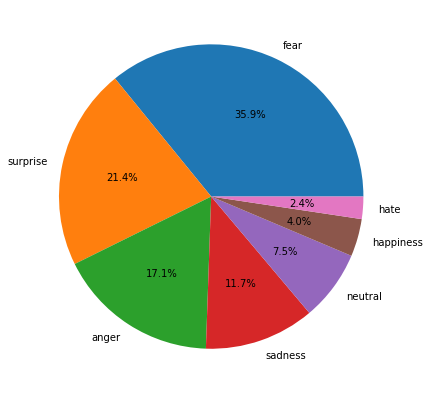

In [ ]:
# Creating plot
fig = plt.figure(figsize =(10, 7))
#plt.pie(results0['emo1'], labels = list(e_dict.values()))
plt.pie(results0['emo1'].value_counts(), labels=['fear','surprise','anger','sadness','neutral','happiness','hate'], autopct = '%1.1f%%')
# show plot
plt.show()

In [ ]:
e_dict_to_eng = {'공포' : 'fear', '놀람' : 'surprise', '분노' :'anger', '슬픔':'sadness',
         '중립':'neutral', '행복':'happiness', '혐오':'hate'}

In [ ]:
pd.DataFrame(results0['emo1'].value_counts()).index.map(e_dict_to_eng)

Index(['hate', 'anger', 'neutral', 'fear', 'surprise', 'sadness', 'happiness'], dtype='object')

TypeError: ignored

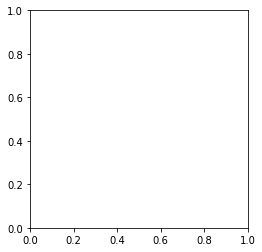

In [ ]:
plt.pie(results0['emo1'].value_counts(), pd.DataFrame(results0['emo1'].value_counts()).index.map(e_dict_to_eng).tolist(), autopct = '%1.1f%%')

In [ ]:
pd.DataFrame(results0['emo1'].value_counts()).index.map(e_dict_to_eng).tolist()

['hate', 'anger', 'neutral', 'fear', 'surprise', 'sadness', 'happiness']

In [ ]:
rslt

,comments,emo1,emo2,pred_over0,topic
0,요즘엔 휠체어도 속도내고 빨간불에 지나가고 하더라구요. 그럼 그냥 뛰어다니지 장애인...,혐오,분노,"[6, 2, 1]",0
1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ,행복,놀람,"[5, 1]",0
2,저래서 차에 치이면 100%차주가 피보는거지 드럽운법때문에,분노,혐오,"[2, 6]",0
3,장애가 권리고 벼슬인 사람들이 있습니다,중립,혐오,"[4, 6, 3]",0
4,수동휠체어에 연결해서 전동휠체어처럼 만들어주는 기기입니다. 대부분 수입이기도하고 장...,중립,행복,"[4, 5, 1]",0
...,...,...,...,...,...
11541,킥보드 강력하게 단속해야 된다,분노,혐오,"[2, 6, 4]",5
11542,킥보드 자체가 무게중심은 윗쪽에 있는데도 작은 바퀴로 인해 조그만 노면변화도 충격이...,공포,혐오,"[0, 6, 4]",5
11543,"대구 진짜 심각합니다 시청, 구청들은 대체 뭐합니까 ‘보호장구가 뭐에요’ 이러듯이 ...",혐오,분노,"[6, 2]",5
11544,법이 솜방망이 처벌로하니 그런것이다 벌금을 물린다고 해도 재벌들은 껌값이니 벌...,혐오,NaN,[6],5


In [ ]:
results0 = rslt[rslt['topic'] == 0]

In [ ]:
results1 = rslt[rslt['topic'] == 1]
results2 = rslt[rslt['topic'] == 2]
results3 = rslt[rslt['topic'] == 3]
results4 = rslt[rslt['topic'] == 4]
results5 = rslt[rslt['topic'] == 5]

In [ ]:
import pandas as pd

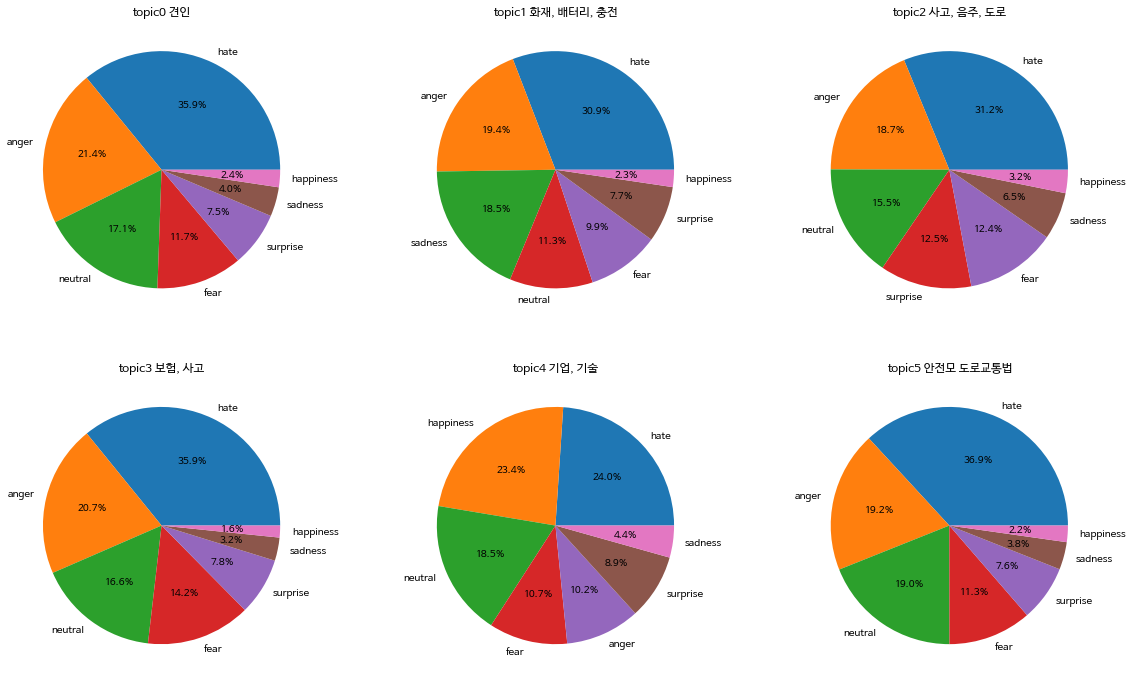

In [ ]:
fig = plt.figure(figsize =(20, 12))

plt.subplot(2,3,1) 
plt.title('topic0 견인')
plt.pie(results0['emo1'].value_counts(), labels= pd.DataFrame(results0['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(2,3,2) 
plt.title('topic1 화재, 배터리, 충전')
plt.pie(results1['emo1'].value_counts(), labels=pd.DataFrame(results1['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(2,3,3) 
plt.title('topic2 사고, 음주, 도로')
plt.pie(results2['emo1'].value_counts(), labels=pd.DataFrame(results2['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(234)
plt.title('topic3 보험, 사고')
plt.pie(results3['emo1'].value_counts(), labels=pd.DataFrame(results3['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(235) 
plt.title('topic4 기업, 기술')
plt.pie(results4['emo1'].value_counts(), labels=pd.DataFrame(results4['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(236)
plt.title('topic5 안전모 도로교통법')
plt.pie(results5['emo1'].value_counts(), labels=pd.DataFrame(results5['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.show()

In [ ]:
results0 = results_etc[results_etc['topic'] == 0]
results1 = results_etc[results_etc['topic'] == 1]
results2 = results_etc[results_etc['topic'] == 2]
results3 = results_etc[results_etc['topic'] == 3]
results4 = results_etc[results_etc['topic'] == 4]
results5 = results_etc[results_etc['topic'] == 5]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_

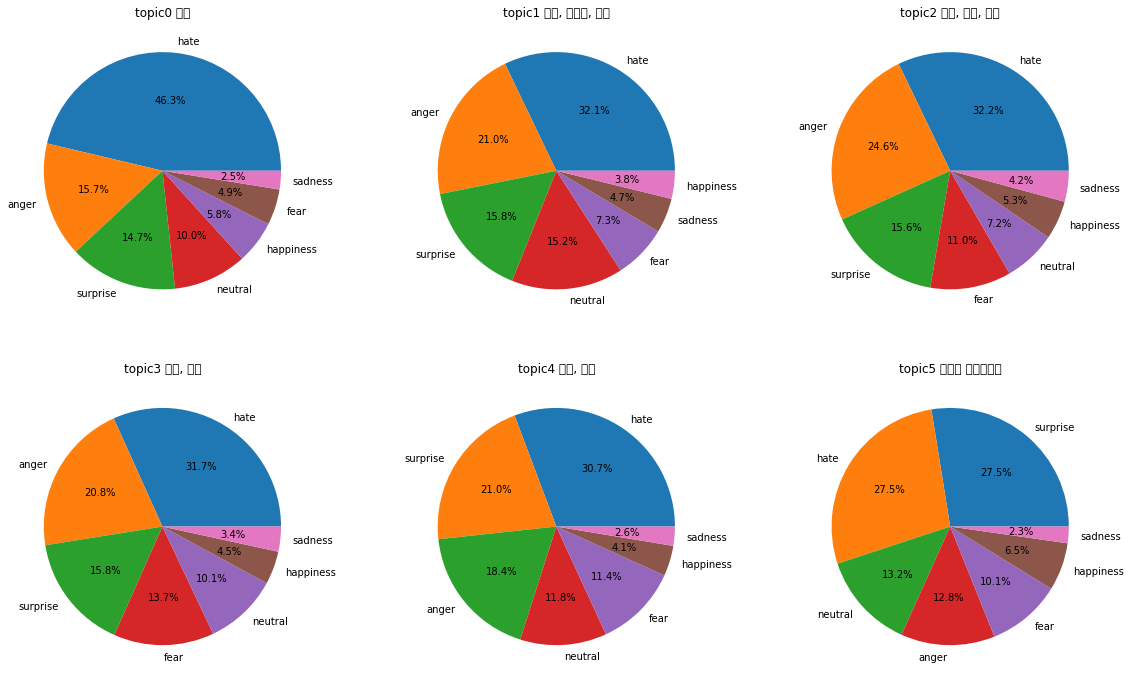

In [ ]:
fig = plt.figure(figsize =(20, 12))

plt.subplot(2,3,1) 
plt.title('topic0 ')
plt.pie(results0['emo1'].value_counts(), labels= pd.DataFrame(results0['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(2,3,2) 
plt.title('topic1 화재, 배터리, 충전')
plt.pie(results1['emo1'].value_counts(), labels=pd.DataFrame(results1['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(2,3,3) 
plt.title('topic2 사고, 음주, 도로')
plt.pie(results2['emo1'].value_counts(), labels=pd.DataFrame(results2['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(234)
plt.title('topic3 보험, 사고')
plt.pie(results3['emo1'].value_counts(), labels=pd.DataFrame(results3['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(235) 
plt.title('topic4 기업, 기술')
plt.pie(results4['emo1'].value_counts(), labels=pd.DataFrame(results4['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(236)
plt.title('topic5 안전모 도로교통법')
plt.pie(results5['emo1'].value_counts(), labels=pd.DataFrame(results5['emo1'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.show()

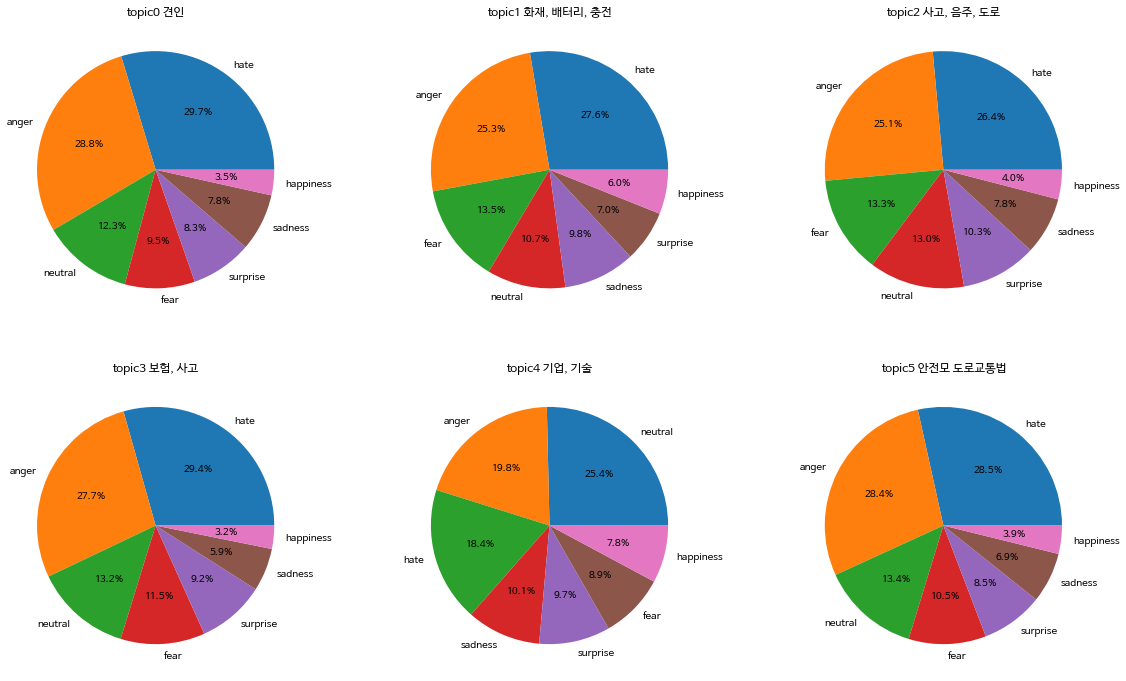

In [ ]:
fig = plt.figure(figsize =(20, 12))

plt.subplot(2,3,1) 
plt.title('topic0 견인')
plt.pie(results0['emo2'].value_counts(), labels= pd.DataFrame(results0['emo2'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(2,3,2) 
plt.title('topic1 화재, 배터리, 충전')
plt.pie(results1['emo2'].value_counts(), labels=pd.DataFrame(results1['emo2'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(2,3,3) 
plt.title('topic2 사고, 음주, 도로')
plt.pie(results2['emo2'].value_counts(), labels=pd.DataFrame(results2['emo2'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(234)
plt.title('topic3 보험, 사고')
plt.pie(results3['emo2'].value_counts(), labels=pd.DataFrame(results3['emo2'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(235) 
plt.title('topic4 기업, 기술')
plt.pie(results4['emo2'].value_counts(), labels=pd.DataFrame(results4['emo2'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.subplot(236)
plt.title('topic5 안전모 도로교통법')
plt.pie(results5['emo2'].value_counts(), labels=pd.DataFrame(results5['emo2'].value_counts()).index.map(e_dict_to_eng), autopct = '%1.1f%%')
plt.show()

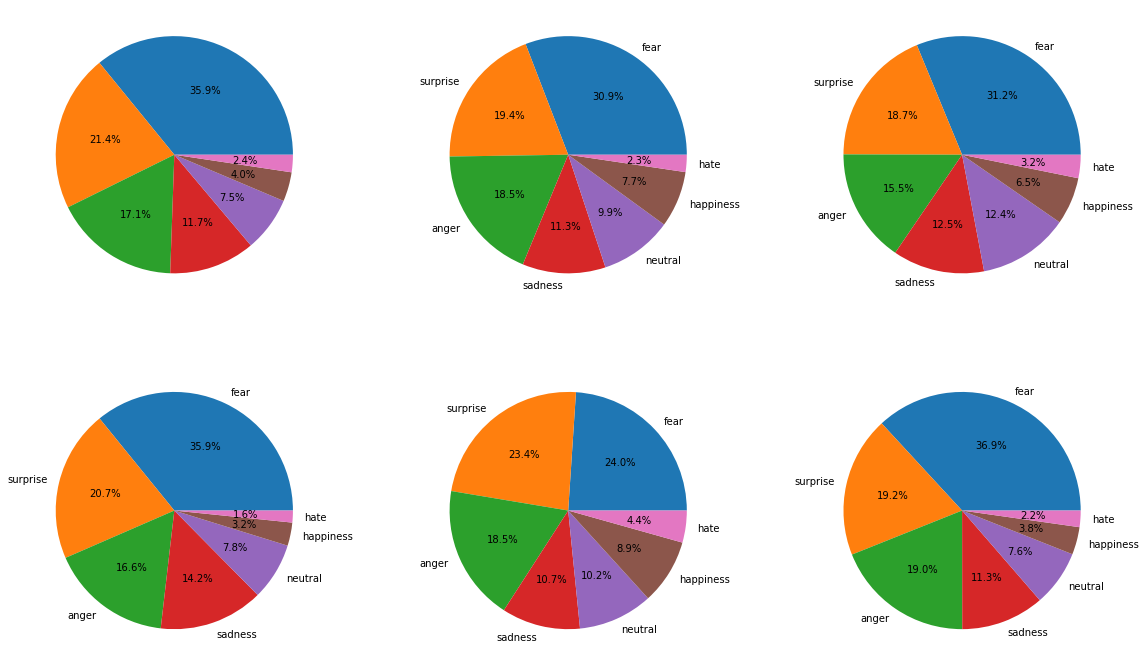

In [ ]:
fig = plt.figure(figsize =(20, 12))

plt.subplot(2,3,1) 
plt.pie(results0['emo1'].value_counts(), autopct = '%1.1f%%')
plt.subplot(2,3,2) 
plt.pie(results1['emo1'].value_counts(), labels=['fear','surprise','anger','sadness','neutral','happiness','hate'], autopct = '%1.1f%%')
plt.subplot(2,3,3) 
plt.pie(results2['emo1'].value_counts(), labels=['fear','surprise','anger','sadness','neutral','happiness','hate'], autopct = '%1.1f%%')
plt.subplot(234)
plt.pie(results3['emo1'].value_counts(), labels=['fear','surprise','anger','sadness','neutral','happiness','hate'], autopct = '%1.1f%%')
plt.subplot(235) 
plt.pie(results4['emo1'].value_counts(), labels=['fear','surprise','anger','sadness','neutral','happiness','hate'], autopct = '%1.1f%%')
plt.subplot(236)
plt.pie(results5['emo1'].value_counts(), labels=['fear','surprise','anger','sadness','neutral','happiness','hate'], autopct = '%1.1f%%')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
topic6_0 = topic6[0]
comments0 = topic6_0['comments']

In [ ]:
comment0 = pre_comments(comments0)

In [ ]:
len(comment0)

249

In [ ]:
results0 = final_label(comment0)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/409 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/409 [00:00<?, ?it/s]

In [ ]:
results0

,comments,emo1,emo2,pred_over0
0,요즘엔 휠체어도 속도내고 빨간불에 지나가고 하더라구요. 그럼 그냥 뛰어다니지 장애인...,혐오,분노,"[6, 2, 1]"
1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ표정 ㅋㅋㅋㅋㅋㅋ,행복,놀람,"[5, 1]"
2,저래서 차에 치이면 100%차주가 피보는거지 드럽운법때문에,분노,혐오,"[2, 6]"
3,장애가 권리고 벼슬인 사람들이 있습니다,중립,혐오,"[4, 6, 3]"
4,수동휠체어에 연결해서 전동휠체어처럼 만들어주는 기기입니다. 대부분 수입이기도하고 장...,중립,행복,"[4, 5, 1]"
...,...,...,...,...
6530,싹다 쓸어갔음 좋겠다 도데체 저런거는 누가 허가 해준거야,혐오,분노,"[6, 2, 4]"
6531,야밤에 보도위로 자전거 휙휙 지나가는거 위험해보이던데 정부에서 확실한 조치를 취해주...,공포,중립,"[0, 4]"
6532,안전하고 쾌적한 환경을 만듭시다,중립,행복,"[4, 5]"
6533,전국적으로 실시해라\n아주 개판이더라,혐오,분노,"[6, 2]"


In [ ]:
# 6개 부분 불러와서 적용

path = '/content/drive/MyDrive/text_data/section_pickle/'

with open(path+'economy_list.pickle', 'rb') as f:
    ec = pickle.load(f)

with open(path+'global_list.pickle', 'rb') as f:
    gb = pickle.load(f)
    
with open(path+'itscience_list.pickle', 'rb') as f:
    its = pickle.load(f)

with open(path+'lifeculture_list.pickle', 'rb') as f:
    lc = pickle.load(f)

with open(path+'politics_list.pickle', 'rb') as f:
    pol = pickle.load(f)

with open(path+'social_list.pickle', 'rb') as f:
    sc = pickle.load(f)

In [ ]:
def pic_cm(data):
  cm = pd.DataFrame({'sentence' : sum(data,[])})
  data_cm = cm_transform(cm)
  cm['predict'] = predict_set(data_cm)
  cm['emotion'] = cm['predict'].map(e_dict)
  return cm

In [ ]:
economy = pic_cm(ec)
global_ = pic_cm(gb)
it_science = pic_cm(its)
life_culture = pic_cm(lc)
politics = pic_cm(pol)
social = pic_cm(sc)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/408 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/488 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/615 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/880 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/1386 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/817 [00:00<?, ?it/s]

In [ ]:
economy['emotion'].value_counts()

혐오    2097
분노    1372
놀람    1030
중립     992
공포     478
슬픔     309
행복     249
Name: emotion, dtype: int64

In [ ]:
politics['emotion'].value_counts()

혐오    10264
분노     3470
놀람     3269
중립     2223
행복     1294
공포     1086
슬픔      562
Name: emotion, dtype: int64

In [ ]:
social['emotion'].value_counts()

혐오    4200
분노    3211
놀람    2033
공포    1442
중립     937
행복     688
슬픔     550
Name: emotion, dtype: int64

In [ ]:
it_science['emotion'].value_counts()

혐오    2706
놀람    2706
중립    1298
분노    1258
공포     997
행복     640
슬픔     222
Name: emotion, dtype: int64

In [ ]:
global_['emotion'].value_counts()

혐오    2396
놀람    1637
분노    1433
중립     920
공포     887
행복     323
슬픔     204
Name: emotion, dtype: int64

In [ ]:
life_culture['emotion'].value_counts()

혐오    4464
분노    2924
놀람    2227
공포    1923
중립    1414
행복     634
슬픔     480
Name: emotion, dtype: int64

예측값 전체 라벨 리스트로 확인해보기

In [ ]:
# 예측 함수 리스트 형식 생성
max_len = 64
batch_size = 16

def predict_set_list(dataset_test):

    test_acc = 0.0

    tokenizer = get_tokenizer()
    tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

    data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

    test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

    out_list =[]

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        output = out.detach().cpu().tolist()

        test_acc += calc_accuracy(out, label)
        acc = test_acc / (batch_id+1)

        out_list.append(output)

    return out_list

In [ ]:
def pic_cm_list(data):
  cm = pd.DataFrame({'sentence' : sum(data,[])})
  data_cm = cm_transform(cm)
  cm = predict_set_list(data_cm)
  return sum(cm,[])

In [ ]:
def final_label(data):
  comment_label = pic_cm_list(data)
  label_f = [np.argsort(i).tolist()[::-1][:len([x for x in i if x > 0])] for i in comment_label]

  data_f = pd.DataFrame({'sentence' : sum(data,[])})
  data_f['predict'] = label_f

  split_df = pd.DataFrame(data_f['predict'].tolist())

  data_final = pd.concat([data_f, split_df], axis = 1)

  return data_final

In [ ]:
economy = final_label(ec)
global_ = final_label(gb)
it_science = final_label(its)
life_culture = final_label(lc)
politics = final_label(pol)
social = final_label(sc)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/408 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/488 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/615 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/880 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/1386 [00:00<?, ?it/s]

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|          | 0/817 [00:00<?, ?it/s]

In [ ]:
# filter
fil = (politics[0] == 5) & (politics[1] == 4)
fil
politics[fil].sample(n=30)

,sentence,predict,0,1,2,3,4
6245,"""저는 안후보님 지지합니다. 제 자신을 넘어 가족, 지인, 지역사회까지 뜨거운 지지...","[5, 4]",5,4.0,NaN,NaN,NaN
9967,"""안철수~파팅!!!""","[5, 4, 2]",5,4.0,2.0,NaN,NaN
21925,"""끝까지 응원해주세요""","[5, 4]",5,4.0,NaN,NaN,NaN
9118,"""윤석열이 공부는 잘하고 순수한 사람인듯... 허튼소리안하고 누구 뒷담도 안까고.....","[5, 4, 1]",5,4.0,1.0,NaN,NaN
13031,"""ㅋㅋㅋㅋ 완전 초중딩 반장선거 수준인듯 ㅋㅋㅋㅋ 하교전 매일 친구들 책상 닦겠다던...","[5, 4, 6]",5,4.0,6.0,NaN,NaN
18700,"""불타는 마음을 누르고 이른새벽 지하철역에서 인사를 하는건 그래도 정권교체를 하겠다...","[5, 4]",5,4.0,NaN,NaN,NaN
20681,"""토론에는 대본도 없고 코치 받아도 아는게 없는데 어찌 대답할래? 코미디프로보다 윤...","[5, 4]",5,4.0,NaN,NaN,NaN
16459,"""국민이 부른 윤석렬 국민에게만 충성한다""","[5, 4]",5,4.0,NaN,NaN,NaN
7874,"""이준석 힘내라 그리고 이나라 진짜우익의 진면모를 보여주길바란다""","[5, 4, 2, 6]",5,4.0,2.0,6.0,NaN
16941,"""윤석열 화이팅""","[5, 4]",5,4.0,NaN,NaN,NaN


In [ ]:
# 현재 데이터로 할수 있는거 ????

# -> 전처리한 댓글 데이터 -> pretrain된 kobert 모델에 넣어서 예측값 생성 -> 긍정 / 부정 여부 확인을 통해 부정의견의 비율이 얼마나 되는지 확인해보자